- Data from: https://github.com/shahar603/Telemetry-Data/tree/master/SpaceX%20CRS-10

In [58]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [68]:
input_file = sorted((Path("..") / "data").glob("*raw.xlsx"))[0]
events_file = sorted((Path("..") / "data").glob("*events.xlsx"))[0]

In [69]:
with pd.ExcelFile(input_file) as crs_file:
    sheet_names = crs_file.sheet_names
    crs_10_df = pd.read_excel(crs_file, sheet_name=sheet_names[0])

In [70]:
with pd.ExcelFile(events_file) as events_file:
    events_df = pd.read_excel(events_file, sheet_name=events_file.sheet_names[0], header=0)

In [71]:
crs_10_df.head()

,time,velocity,altitude
0,0.000,0.000,0.0
1,0.033,0.555,0.0
2,0.066,0.555,0.0
3,0.100,0.555,0.0
4,0.133,0.555,0.0


In [72]:
events_df_clean = (events_df
 .dropna(subset='Time [s]')
 .sort_values("Time [s]")
)

events_df_clean

,Event,Time [s]
13,throttle_down_start,50.0
14,throttle_down_end,66.0
3,maxq,75.0
6,meco,143.0
10,ses1,154.0


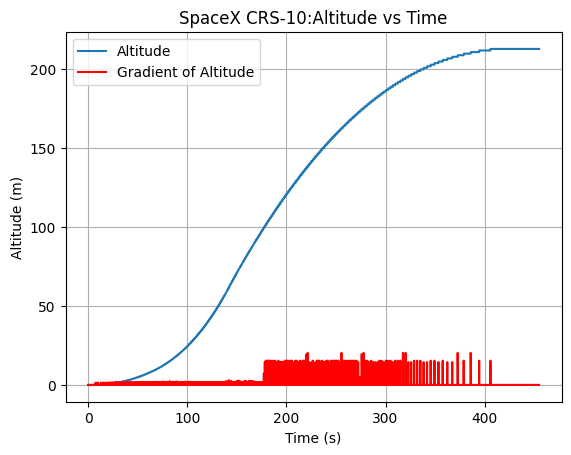

In [73]:
crs_10_df['gradient_of_altitude'] = np.gradient(crs_10_df["altitude"], crs_10_df["time"])

plt.plot(crs_10_df["time"], crs_10_df["altitude"], label="Altitude")
plt.plot(crs_10_df["time"], crs_10_df["gradient_of_altitude"], c="r", label="Gradient of Altitude")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.title("SpaceX CRS-10:Altitude vs Time")
plt.legend()
plt.grid()  
plt.show();

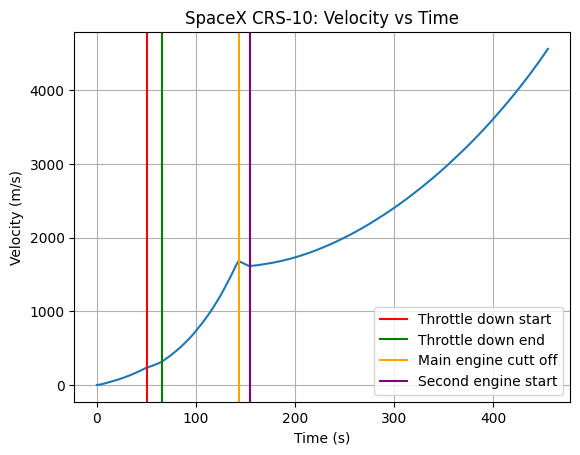

In [74]:
plt.plot(crs_10_df["time"], crs_10_df["velocity"])
plt.axvline(x=50, label="Throttle down start", c='r')
plt.axvline(x=66, label="Throttle down end", c='g')
plt.axvline(x=143, label="Main engine cutt off", c='orange')
plt.axvline(x=154, label="Second engine start", c='purple')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("SpaceX CRS-10: Velocity vs Time")
plt.legend()
plt.grid();

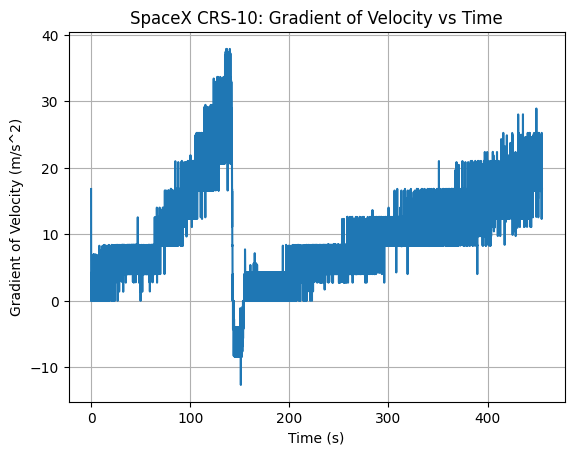

In [75]:
crs_10_df['gradient_of_velocity'] = np.gradient(crs_10_df["velocity"], crs_10_df["time"])

plt.plot(crs_10_df["time"], crs_10_df["gradient_of_velocity"])
plt.xlabel("Time (s)")
plt.ylabel("Gradient of Velocity (m/s^2)")
plt.title("SpaceX CRS-10: Gradient of Velocity vs Time")
plt.grid();

# Z-score outliers

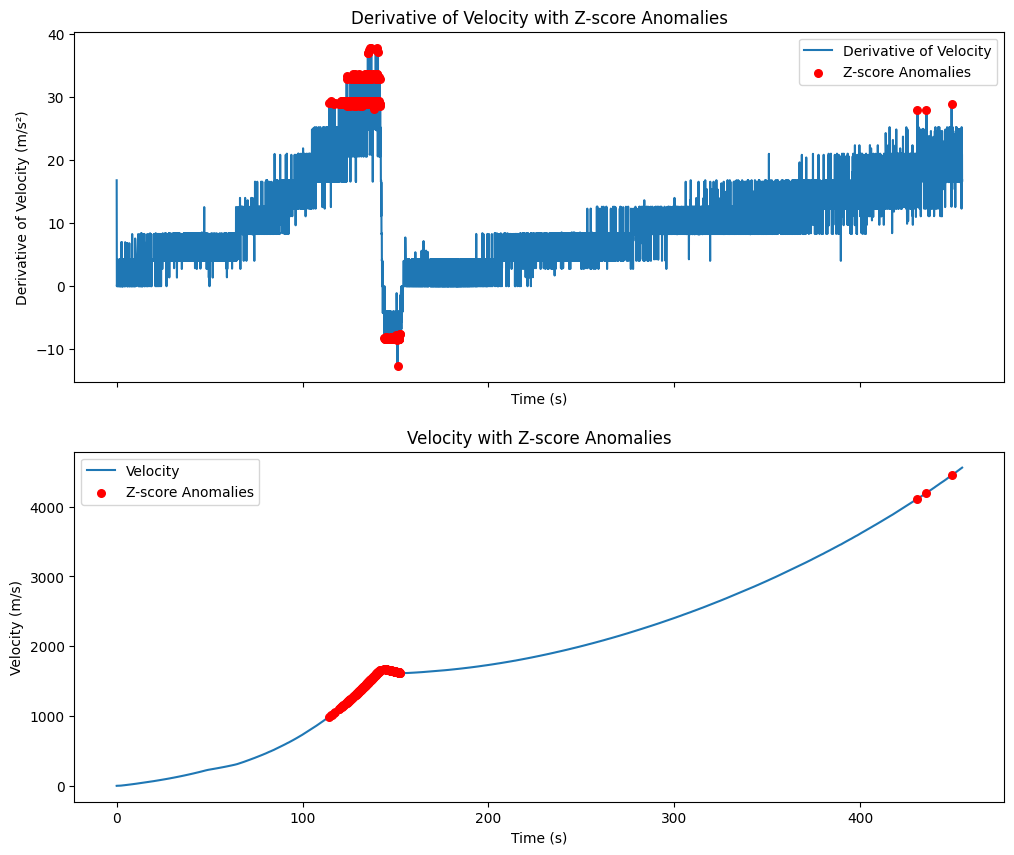

In [76]:
z_scores = np.abs(stats.zscore(crs_10_df["gradient_of_velocity"]))
threshold_zscore = 2.5
anomalies_zscore = z_scores > threshold_zscore

time_anomalies_z_score = crs_10_df.loc[anomalies_zscore, "time"]
gradient_anomalies_z_score = crs_10_df.loc[anomalies_zscore, "gradient_of_velocity"]
velo_anomalies_z_score = crs_10_df.loc[anomalies_zscore, "velocity"]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax1.plot(crs_10_df['time'],
         crs_10_df['gradient_of_velocity'],
         label="Derivative of Velocity"
         )
ax1.scatter(x=time_anomalies_z_score,
            y=gradient_anomalies_z_score,
            color='red', 
            s=30,
            zorder=5, 
            label='Z-score Anomalies')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Derivative of Velocity (m/s²)")
ax1.set_title("Derivative of Velocity with Z-score Anomalies")
ax1.legend();

ax2.plot(crs_10_df['time'],
         crs_10_df['velocity'],
         label="Velocity"
         )
ax2.scatter(x=time_anomalies_z_score,
            y=velo_anomalies_z_score,
            color='red', 
            s=30,
            zorder=5, 
            label='Z-score Anomalies')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
ax2.set_title("Velocity with Z-score Anomalies")
ax2.legend();

# IQR Outliers

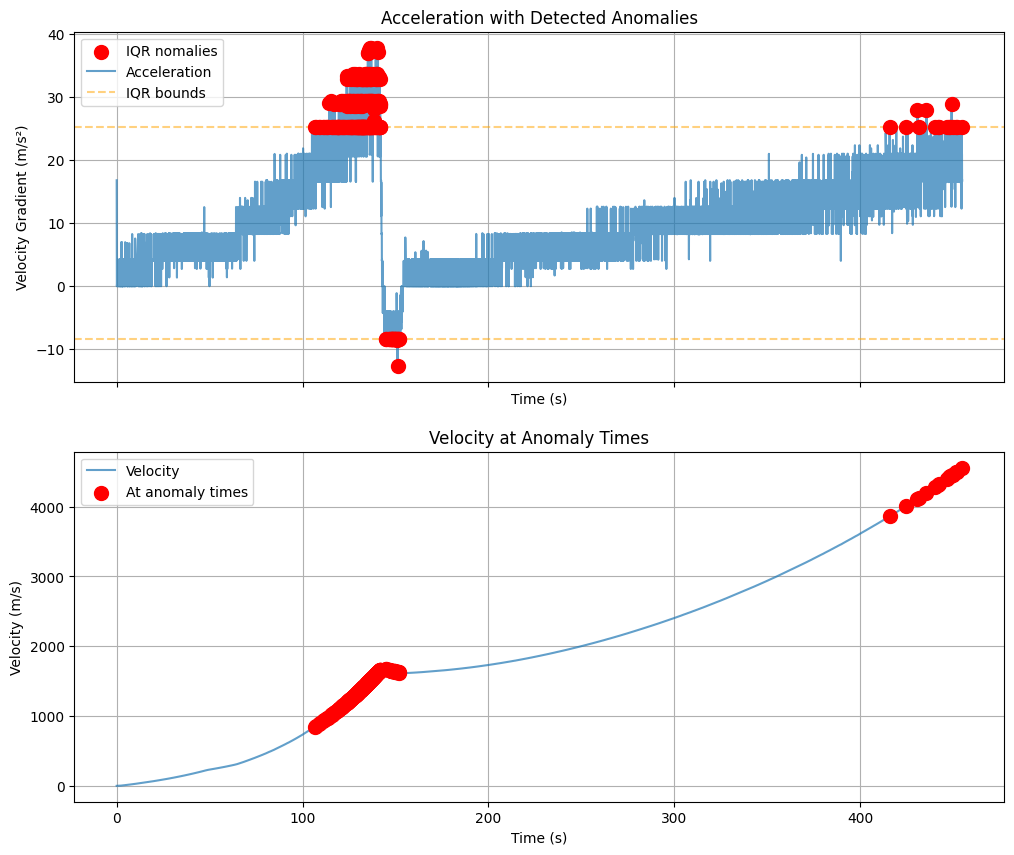

In [77]:
Q1 = crs_10_df["gradient_of_velocity"].quantile(0.25)
Q3 = crs_10_df["gradient_of_velocity"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
iqr_anomalies = (crs_10_df["gradient_of_velocity"] < lower_bound) | (crs_10_df["gradient_of_velocity"] > upper_bound)

time_anomalies_iqr = crs_10_df.loc[iqr_anomalies, "time"]
gradient_anomalies_iqr = crs_10_df.loc[iqr_anomalies, "gradient_of_velocity"]
velo_anomalies_iqr = crs_10_df.loc[iqr_anomalies, "velocity"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax1.scatter(time_anomalies_iqr, 
            gradient_anomalies_iqr, 
            color='red', 
            s=100, 
            label='IQR nomalies', 
            zorder=5)
ax1.plot(crs_10_df["time"], 
         crs_10_df["gradient_of_velocity"], 
         label="Acceleration", 
         alpha=0.7)
ax1.axhline(y=upper_bound, 
            color='orange', 
            linestyle='--', 
            alpha=0.5, 
            label='IQR bounds')
ax1.axhline(y=lower_bound, 
            color='orange', 
            linestyle='--', 
            alpha=0.5)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Velocity Gradient (m/s²)")
ax1.set_title("Acceleration with Detected Anomalies")
ax1.legend()
ax1.grid()

ax2.plot(crs_10_df["time"], 
         crs_10_df["velocity"], 
         label="Velocity", 
         alpha=0.7)
ax2.scatter(time_anomalies_iqr, 
            velo_anomalies_iqr, 
            color='red', 
            s=100, 
            label='At anomaly times', 
            zorder=5)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
ax2.set_title("Velocity at Anomaly Times")
ax2.legend()
ax2.grid();
